In [2]:
import os
import PIL
import math
import gdown
import random

from os import path
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional

from pathlib import Path

from tqdm.notebook import tqdm
from zipfile import ZipFile

import torch
import torchvision
import torch.utils.data
import torch.utils.data.distributed
import torch.nn.functional as F

from torch import nn
from torch import optim
from torch.optim import Adam, RMSprop
from torch import autograd
from torchvision import transforms
from torch.autograd import Variable

from IPython.display import Image

### Preparing the environment

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
out_dir = 'outputs'
vae_chkpt = 'vae_chkpt'
d_chkpt = 'd_chkpt'
g_chkpt = 'g_chkpt'
data_dir = 'data'

if not path.exists(out_dir):
    os.makedirs(out_dir)
if not path.exists(vae_chkpt):
    os.makedirs(vae_chkpt)
if not path.exists(d_chkpt):
    os.makedirs(d_chkpt)
if not path.exists(g_chkpt):
    os.makedirs(g_chkpt)
if not path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

### Util functions

In [8]:
def extract(file, output_dir):
  with ZipFile(file, 'r') as zObject:
    print('Data extraction started...')
    zObject.extractall(output_dir)
    print('Data extraction completed')

In [9]:
def save_model(name, model, it, path):
    filename = f'{name}_{it}.pt'
    save_path = os.path.join(path, filename)
    torch.save(model.state_dict(), save_path)

In [10]:
def save_images(imgs, outfile, nrow=8):
    imgs = imgs / 2 + 0.5
    torchvision.utils.save_image(imgs, outfile, nrow=nrow)

### Download CelebA dataset

In [12]:
url = 'https://drive.google.com/uc?id=1y0YXszFp8BLP-QwoMrVG4vEXgQMl4xo0'
dataset = 'img_align_celeba.zip'
gdown.download(url, dataset, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1y0YXszFp8BLP-QwoMrVG4vEXgQMl4xo0
To: /home/ubuntu/img_align_celeba.zip
100%|██████████| 1.50G/1.50G [00:44<00:00, 33.3MB/s]


'img_align_celeba.zip'

In [13]:
extract(dataset, data_dir)

Data extraction started...
Data extraction completed


### Prepare dataloader for CelebA dataset

In [51]:
batch_size = 64

image_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
    ])

CELEBA_PATH = "data/img_align_celeba/"

class CelebA(torch.utils.data.Dataset):
  def __init__(self, root_path:str, transform: Optional[Callable] = None):
    super().__init__()
    self.transform = transform
    self.root_path = root_path
    self.img_paths = os.listdir(root_path)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx:int):
    img = PIL.Image.open(os.path.join(self.root_path, self.img_paths[idx]))
    if self.transform: img = self.transform(img)
    return img

full_dataset = CelebA(CELEBA_PATH, transform=image_transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

In [15]:
def init_weights(model):
  if type(model) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
    model.weight.data.normal_(0.0, std=0.02)
    if model.bias is not None:
      model.bias.data.fill_(0)

def reparametrize(mu, logvar):
  std = logvar.div(2).exp()
  eps = std.data.new(std.size()).normal_()
  return mu + std*eps

In [16]:
c_dim = 20
z_dim = 256

## β-VAE Architecture

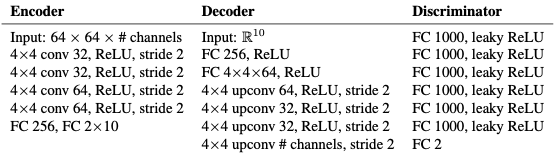

### Encoder Block

In [17]:
class Encoder(nn.Module):
  def __init__(self, c_dim=c_dim, nc=3, distil=False):
    super(Encoder, self).__init__()

    self.c_dim = c_dim
    self.nc = nc
    self.distil = distil

    self.conv_layer = nn.Sequential(
        nn.Conv2d(nc, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(32, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(32, 64, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(64, 64, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(64, 256, 4, 1),
        nn.ReLU(True),
    )

    self.linear_layer = nn.Linear(256, c_dim*2)

  def forward(self, x):
    if self.distil:
      x = x.add(1).div(2)
      if (x.size(2) > 64) or (x.size(3) > 64):
        x = F.adaptive_avg_pool2d(x, (64, 64))
    
    x = self.conv_layer(x)
    x = x.view((-1, 256*1*1))
    
    return self.linear_layer(x)

### Decoder Block

In [18]:
class Decoder(nn.Module):
  def __init__(self, c_dim=c_dim, nc=3):
    super(Decoder, self).__init__()
    
    self.c_dim = c_dim
    self.nc = nc

    self.conv_layer = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 64, 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 64, 4, 2, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, nc, 4, 2, 1),
    )

    self.linear_layer = nn.Linear(c_dim, 256)

  def forward(self, c):
    c = self.linear_layer(c)
    c = c.view((-1, 256, 1, 1))
    return self.conv_layer(c)

### β-VAE Model

In [20]:
class bVAE(nn.Module):
  def __init__(self, c_dim=c_dim, nc=3, distil=False):
    super(bVAE, self).__init__()
    
    self.c_dim = c_dim
    self.nc = nc
    self.encoder = Encoder(c_dim, nc, distil)
    self.decoder = Decoder(c_dim, nc)
    self.apply(init_weights)

  def forward(self, x, c, encode_only, decode_only):
    if encode_only:
      c, mu, logvar = self._encode(x)
      return c, mu, logvar
    elif decode_only:
      x_recon = self._decode(c)
      return x_recon
    else:
      c, mu, logvar = self._encode(x)
      x_recon = self._decode(c)
      return x_recon, c, mu, logvar

  def __call__(self, x=None, c=None, encode_only=False, decode_only=False):
      return self.forward(x, c, encode_only, decode_only)

  def _encode(self, x):
    distributions = self.encoder(x)
    mu = distributions[:, :self.c_dim]
    logvar = distributions[:, self.c_dim:]
    c = reparametrize(mu, logvar)
    return c, mu, logvar

  def _decode(self, c):
    return self.decoder(c)

## ID-GAN Architecture

### Generator

In [21]:
class Generator(nn.Module):
  def __init__(self, dim=z_dim, nc=3):
    super(Generator, self).__init__()
    self.dim = dim
    self.nc = nc

    self.conv_layer = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 64, 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 64, 4, 2, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, nc, 4, 2, 1),
        nn.Tanh()
    )

    self.linear_layer = nn.Linear(dim, 256)

  def forward(self, c):
    c = self.linear_layer(c)
    c = c.view((-1, 256, 1, 1))
    return self.conv_layer(c)

### Discriminator

In [22]:
class Discriminator(nn.Module):
  def __init__(self, nc=3):
    super(Discriminator, self).__init__()
    self.nc = nc

    self.conv_layer = nn.Sequential(
        nn.Conv2d(nc, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(32, 32, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(32, 64, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(64, 64, 4, 2, 1),
        nn.ReLU(True),
        nn.Conv2d(64, 256, 4, 1),
        nn.ReLU(True),
    )

    self.linear_layer = nn.Linear(256, 1)

  def forward(self, x):
    x = self.conv_layer(x)
    x = x.view((-1, 256*1*1))

    return self.linear_layer(x)

## Rsenet Generator/Discriminator

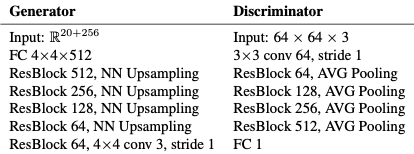

### Resnet Generator

In [23]:
class ResnetGenerator(nn.Module):
    def __init__(self, z_dim, size, nfilter=64, nfilter_max=512, **kwargs):
        super().__init__()
        self.z_dim = z_dim

        s0 = self.s0 = 4
        nf = self.nf = nfilter
        nf_max = self.nf_max = nfilter_max

        # Submodules
        nlayers = int(np.log2(size / s0))
        self.nf0 = min(nf_max, nf * 2**nlayers)

        self.fc = nn.Linear(z_dim, self.nf0*s0*s0)

        blocks = []
        for i in range(nlayers):
            nf0 = min(nf * 2**(nlayers-i), nf_max)
            nf1 = min(nf * 2**(nlayers-i-1), nf_max)
            blocks += [
                ResnetBlock(nf0, nf1),
                nn.Upsample(scale_factor=2)
            ]

        blocks += [
            ResnetBlock(nf, nf),
        ]

        self.resnet = nn.Sequential(*blocks)
        self.conv_img = nn.Conv2d(nf, 3, 3, padding=1)

    def forward(self, z):
        batch_size = z.size(0)
        out = self.fc(z)
        out = out.view(batch_size, self.nf0, self.s0, self.s0)
        out = self.resnet(out)
        out = self.conv_img(actvn(out))
        out = torch.tanh(out)
        return out

### Resnet Discriminator

In [24]:
class ResnetDiscriminator(nn.Module):
    def __init__(self, z_dim, size, nfilter=64, nfilter_max=512):
        super().__init__()
        s0 = self.s0 = 4
        nf = self.nf = nfilter
        nf_max = self.nf_max = nfilter_max

        # Submodules
        nlayers = int(np.log2(size / s0))
        self.nf0 = min(nf_max, nf * 2**nlayers)

        blocks = [
            ResnetBlock(nf, nf)
        ]

        for i in range(nlayers):
            nf0 = min(nf * 2**i, nf_max)
            nf1 = min(nf * 2**(i+1), nf_max)
            blocks += [
                nn.AvgPool2d(3, stride=2, padding=1),
                ResnetBlock(nf0, nf1),
            ]

        self.conv_img = nn.Conv2d(3, 1*nf, 3, padding=1)
        self.resnet = nn.Sequential(*blocks)
        self.fc = nn.Linear(self.nf0*s0*s0, 1)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.conv_img(x)
        out = self.resnet(out)
        out = out.view(batch_size, self.nf0*self.s0*self.s0)
        out = self.fc(actvn(out))
        return out

In [25]:
class ResnetBlock(nn.Module):
    def __init__(self, fin, fout, fhidden=None, is_bias=True):
        super().__init__()
        # Attributes
        self.is_bias = is_bias
        self.learned_shortcut = (fin != fout)
        self.fin = fin
        self.fout = fout
        if fhidden is None:
            self.fhidden = min(fin, fout)
        else:
            self.fhidden = fhidden

        # Submodules
        self.conv_0 = nn.Conv2d(self.fin, self.fhidden, 3, stride=1, padding=1)
        self.conv_1 = nn.Conv2d(self.fhidden, self.fout, 3, stride=1, padding=1, bias=is_bias)
        if self.learned_shortcut:
            self.conv_s = nn.Conv2d(self.fin, self.fout, 1, stride=1, padding=0, bias=False)

    def forward(self, x):
        x_s = self._shortcut(x)
        dx = self.conv_0(actvn(x))
        dx = self.conv_1(actvn(dx))
        out = x_s + 0.1*dx

        return out

    def _shortcut(self, x):
        if self.learned_shortcut:
            x_s = self.conv_s(x)
        else:
            x_s = x
        return x_s


def actvn(x):
    out = F.leaky_relu(x, 2e-1)
    return out

## Lossess

$𝓡(G,q) = \beta𝓡_{VAE}(q) + \lambda𝓡_{ID}(G)$

where

$𝓡_{VAE}(q)= 𝔼_{x \sim 𝕡(x)}[𝐃_{KL}(q_{ϕ}(c|x)||𝕡(c))]$

$𝓡_{ID}(G) = 𝔼_{s ∼ 𝕡(x)}[𝐃_{KL}(q_{ϕ}(c)||𝕡(c|G(s,c)))]$

In [26]:
def recon_loss(x, x_recon, distribution):
  batch_size = x.size(0)
  assert batch_size != 0

  if distribution == 'bernoulli':
    recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='sum').div(batch_size)
  elif distribution == 'gaussian':
    x_recon = torch.sigmoid(x_recon)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum').div(batch_size)
  else:
    raise NotImplementedError

  return recon_loss


def kl_divergence(mu, logvar):
  batch_size = mu.size(0)
  assert batch_size != 0

  if mu.data.ndimension() == 4:
    mu = mu.view(mu.size(0), mu.size(1))
  if logvar.data.ndimension() == 4:
    logvar = logvar.view(logvar.size(0), logvar.size(1))

  kld = (-0.5*(1 + logvar - mu.pow(2) - logvar.exp())).sum(1).mean(0, True)
  return kld

In [52]:
beta = 6.9
beta1 = 0.9
beta2 = 0.999
vae_dist = 'gaussian'

lr = 1e-4

In [53]:
model = bVAE()
model.to(device)
model.apply(init_weights)

optimizer = Adam(model.parameters(), lr=lr, betas=(beta1, beta2))

### β-VAE model training

In [ ]:
losses = []

max_iterations = 1e6
backup = int((10 * max_iterations) / 100)
iteration = 0

end = False

progress = tqdm(total=max_iterations)
progress.update(iteration)

while not end:
  for images in dataloader:

    imgs = images.to(device)

    iteration += 1
    progress.update(1)

    x_recon, c, mu, logvar = model(imgs)

    r_loss = recon_loss(imgs, x_recon, vae_dist)
    kld = kl_divergence(mu, logvar)
    loss = r_loss + beta*kld

    losses.append(loss.item())
    
    # reset gradients
    optimizer.zero_grad()

    # backpropagate
    loss.backward()

    # update weights
    optimizer.step()

    if iteration >= max_iterations:
      save_model('VAE', model, 'Final', vae_chkpt)
      end = True
      break
    elif iteration % backup == 0:
      save_model('VAE', model, iteration, vae_chkpt)
    else:
      pass

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses, label='VAE loss')
plt.legend()
plt.show()

In [ ]:
batch_size = 64

image_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.CenterCrop((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x + 1./128 * torch.rand(x.size())),
    ])

CELEBA_PATH = "data/img_align_celeba/"

class CelebA(torch.utils.data.Dataset):
  def __init__(self, root_path:str, transform: Optional[Callable] = None):
    super().__init__()
    self.transform = transform
    self.root_path = root_path
    self.img_paths = os.listdir(root_path)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx:int):
    img = PIL.Image.open(os.path.join(self.root_path, self.img_paths[idx]))
    if self.transform: img = self.transform(img)
    return img

full_dataset = CelebA(CELEBA_PATH, transform=image_transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

In [ ]:
def compute_loss(d_out, target):
  targets = d_out.new_full(size=d_out.size(), fill_value=target)
  loss = F.binary_cross_entropy_with_logits(d_out, targets)
  return loss

In [ ]:
def infomax(cs, chs):
    c, c_mu, c_logvar = cs
    ch, ch_mu, ch_logvar = chs
    
    loss = (math.log(2*math.pi) + ch_logvar + (c-ch_mu).pow(2).div(ch_logvar.exp()+1e-8)).div(2).sum(1).mean()
    return loss

In [ ]:
def grad(model, enable):
  for p in model.parameters():
    p.requires_grad_(enable)

In [ ]:
vae_path = os.path.join(vae_chkpt, 'VAE_Final.pt')
vae_model = bVAE(distil=True)
vae_model.load_state_dict(torch.load(vae_path))

G = ResnetGenerator(z_dim=z_dim+c_dim, size=64)
D = ResnetDiscriminator(z_dim=z_dim+c_dim, size=64)

vae_model.to(device)
G.to(device)
D.to(device)

In [ ]:
g_lr = d_lr = 1e-4

grad(G, True)
grad(D, True)

optimizers = {
    'G': RMSprop(G.parameters(), lr=g_lr, momentum=0.0),
    'D': RMSprop(D.parameters(), lr=d_lr, momentum=0.0),
}

losses = {
    'D': [],
    'G': []
}

In [ ]:
steps_ratio = 1
dim = 20
z_dim = 256
w = 0.001

max_iterations = 300000
backup = int((10 * max_iterations) / 100)

iteration = -1

step_size = max_iterations // 2
gamma = 1

G_lr_scheduler = optim.lr_scheduler.StepLR(optimizers['G'], step_size=step_size, gamma=gamma, last_epoch=iteration)
D_lr_scheduler = optim.lr_scheduler.StepLR(optimizers['D'], step_size=step_size, gamma=gamma, last_epoch=iteration)

end = False
progress = tqdm(total=max_iterations)
progress.update(iteration)

while not end:
  for images in dataloader:
    
    progress.update(1)
    iteration += 1

    grad(D, True)
    grad(G, False)
    grad(vae_model, False)

    imgs = images.to(device)
    imgs.requires_grad_()

    distribution = torch.distributions.Normal(torch.zeros(z_dim, device=device), 
                                  torch.ones(z_dim, device=device))
    
    z = distribution.sample((batch_size,))

    optimizers['D'].zero_grad()

    d_real = D(imgs)
    d_real_loss = compute_loss(d_real, 1)

    d_real_loss.backward(retain_graph=True)

    reg = 10 * compute_grad(d_real, imgs).mean()
    reg.backward()

    #fake
    with torch.no_grad():
      c, c_mu, c_logvar = cs = vae_model(imgs, encode_only=True)
      z_ = torch.cat([z, c], 1)
      x_fake = G(z_)

    x_fake.requires_grad_()
    d_fake = D(x_fake)
    dloss_fake = compute_loss(d_fake, 0)
    dloss_fake.backward()

    optimizers['D'].step()

    d_loss = (d_real_loss + dloss_fake)
    losses['D'].append(d_loss.item())
    
    if (iteration+1) % steps_ratio == 0:

      grad(G, True)
      grad(vae_model, True)
      grad(D, False)

      vae_model.zero_grad()

      optimizers['G'].zero_grad()

      g_loss = 0

      c, c_mu, c_logvar = cs
      z_ = torch.cat([z, c], 1)
      x_fake = G(z_)
      d_fake = D(x_fake)

      g_loss += compute_loss(d_fake, 1)

      chs = vae_model(x_fake, encode_only=True)
      encloss = infomax(cs, chs)
      g_loss += w * encloss

      losses['G'].append(g_loss.item())

      g_loss.backward()
      optimizers['G'].step()
    
    G_lr_scheduler.step()
    D_lr_scheduler.step()
    
    if iteration == max_iterations:
      save_model('G', G, 'Final', g_chkpt)
      save_model('D', D, 'Final', d_chkpt)
      end = True
      break
    elif iteration % backup == 0:
      save_model('G', G, iteration, g_chkpt)
      save_model('D', D, iteration, d_chkpt)
    else:
      pass

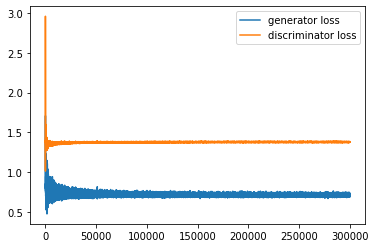

In [95]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

In [88]:
TestGenerator = ResnetGenerator(z_dim=z_dim+c_dim, size=64).to(device)
path = os.path.join(g_chkpt, 'G_Final.pt')
TestGenerator.load_state_dict(torch.load(path))

<All keys matched successfully>

In [89]:
TestGenerator.eval()

ResnetGenerator(
  (fc): Linear(in_features=276, out_features=8192, bias=True)
  (resnet): Sequential(
    (0): ResnetBlock(
      (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): ResnetBlock(
      (conv_0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_s): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): ResnetBlock(
      (conv_0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_s): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (5): Upsample(scale_factor=2.0, mode=nearest)

In [90]:
def create_samples(z):
    with torch.no_grad():
        return TestGenerator(z)

In [91]:
distribution = torch.distributions.Normal(torch.zeros(z_dim+c_dim, device=device), 
                                torch.ones(z_dim+c_dim, device=device))

sample_bs = 64

z = distribution.sample((sample_bs,))

In [92]:
x = create_samples(z)

In [93]:
save_images(x, os.path.join(out_dir, 'output_sample.png'), nrow=8)

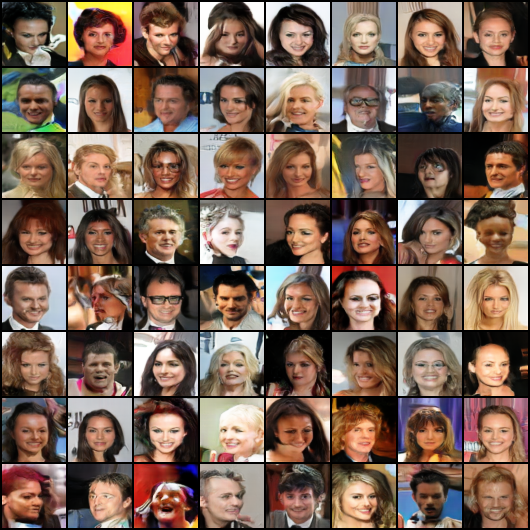

In [94]:
Image(filename=os.path.join(out_dir, 'output_sample.png')) 